# Data Acquisition and Cleaning
This document presents the work done in order to obtain a usable dataset. Indeed, the Million Song Dataset (MSD) was lackluster regarding song features (danceability, energy, etc), which were all set to 0. That's why we decided to take additional steps to improve this dataset.    
In the first part, we import data from the MSD and we decide to keep only some values of interest from this dataset. Next, we query the Spotify API in order to obtain additional information about each song. In the meantime, we also add genre classification for each song from 3 datasets built around the MSD. Finally, we generate a csv which will be our main resource of data for the rest of the project.

We already compressed the generated data as well as the intermediate ones. You can download them at this url:

https://drive.switch.ch/index.php/s/EPkS2fxNrBAYbL0

You need to unzip it inside the root of the project (a new folder data/ should be present at the same level than this notebook => Project/data/).

In [1]:
import pandas as pd
import sqlite3
from sqlite3 import Error
import numpy as np

%load_ext autoreload
%autoreload 2

The following function aims at creating a connection to SQLite database.

In [2]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by the db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)

    return None

We have a quick look at the columns we have at our disposal.

In [3]:
database = "data/track_metadata.db"
conn = create_connection(database)
cur = conn.cursor()
cur.execute("PRAGMA table_info(songs)")
rows = cur.fetchall()
print(rows)

[(0, 'track_id', 'text', 0, None, 1), (1, 'title', 'text', 0, None, 0), (2, 'song_id', 'text', 0, None, 0), (3, 'release', 'text', 0, None, 0), (4, 'artist_id', 'text', 0, None, 0), (5, 'artist_mbid', 'text', 0, None, 0), (6, 'artist_name', 'text', 0, None, 0), (7, 'duration', 'real', 0, None, 0), (8, 'artist_familiarity', 'real', 0, None, 0), (9, 'artist_hotttnesss', 'real', 0, None, 0), (10, 'year', 'int', 0, None, 0)]


Request the dataset and put the data in a dataframe.

In [4]:
cur.execute("SELECT track_id, song_id, artist_id, duration, artist_hotttnesss, year FROM songs ORDER BY track_id")
rows = cur.fetchall()
songs = pd.DataFrame(rows, columns=['track_id', 'song_id', 'artist_id', 'duration', 'artist_hotttnesss', 'year'])

The 3 following cells merge our data from genres classification coming from 3 datasets.

In [5]:
track_genre_cd1 = pd.read_csv('data/msd_tagtraum_cd1.cls', sep='\t', names=['track_id', 'genre1_cd1', 'genre2_cd1'])
songs = track_genre_cd1.merge(songs, on='track_id', how='right')

In [6]:
track_genre_cd1 = pd.read_csv('data/msd_tagtraum_cd2.cls', sep='\t', names=['track_id', 'genre1_cd2', 'genre2_cd2'])
songs = track_genre_cd1.merge(songs, on='track_id', how='right')

In [7]:
track_genre_cd1 = pd.read_csv('data/msd_tagtraum_cd2c.cls', sep='\t', names=['track_id', 'genre1_cd2c', 'genre2_cd2c'])
songs = track_genre_cd1.merge(songs, on='track_id', how='right')

We take look at the analysis of the songs from the MSD

In [8]:
msd_summary_file = pd.HDFStore("data/msd_summary_file.h5")
songs_analysis = msd_summary_file.get('/analysis/songs')
songs_analysis.columns

Index(['analysis_sample_rate', 'audio_md5', 'danceability', 'duration',
       'end_of_fade_in', 'energy', 'idx_bars_confidence', 'idx_bars_start',
       'idx_beats_confidence', 'idx_beats_start', 'idx_sections_confidence',
       'idx_sections_start', 'idx_segments_confidence',
       'idx_segments_loudness_max', 'idx_segments_loudness_max_time',
       'idx_segments_loudness_start', 'idx_segments_pitches',
       'idx_segments_start', 'idx_segments_timbre', 'idx_tatums_confidence',
       'idx_tatums_start', 'key', 'key_confidence', 'loudness', 'mode',
       'mode_confidence', 'start_of_fade_out', 'tempo', 'time_signature',
       'time_signature_confidence', 'track_id'],
      dtype='object')

And add the data we find interesting. Indeed a lot of columns in this dataset are empty and cannot be used.

In [9]:
songs_analysis = songs_analysis[['track_id', 'loudness', 'mode', 'tempo', 'key']]
songs = songs_analysis.merge(songs, on='track_id')
del(songs_analysis)

We do the same operation for the metadata.

In [10]:
songs_metadata = msd_summary_file.get('/metadata/songs')
songs_metadata.columns

Index(['analyzer_version', 'artist_7digitalid', 'artist_familiarity',
       'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location',
       'artist_longitude', 'artist_mbid', 'artist_name', 'artist_playmeid',
       'genre', 'idx_artist_terms', 'idx_similar_artists', 'release',
       'release_7digitalid', 'song_hotttnesss', 'song_id', 'title',
       'track_7digitalid'],
      dtype='object')

In [11]:
songs_metadata = songs_metadata[['song_hotttnesss', 'song_id', 'artist_latitude', 'artist_location', 'artist_longitude']]
songs = songs_metadata.merge(songs, on='song_id')
del(songs_metadata)

And we take a look at the data we have gathered until now.

In [12]:
songs.head()

,song_hotttnesss,song_id,artist_latitude,artist_location,artist_longitude,track_id,loudness,mode,tempo,key,genre1_cd2c,genre2_cd2c,genre1_cd2,genre2_cd2,genre1_cd1,genre2_cd1,artist_id,duration,artist_hotttnesss,year
0,0.542899,SOQMMHC12AB0180CB8,NaN,,NaN,TRMMMYQ128F932D901,-4.829,0,87.002,10,NaN,NaN,NaN,NaN,NaN,NaN,ARYZTJS1187B98C555,252.05506,0.394032,2003
1,0.299877,SOVFVAK12A8C1350D9,NaN,,NaN,TRMMMKD128F425225D,-10.555,1,150.778,9,NaN,NaN,NaN,NaN,NaN,NaN,ARMVN3U1187FB3A1EB,156.55138,0.356992,1995
2,0.617871,SOGTUKN12AB017F4F1,55.8578,"Glasgow, Scotland",-4.24251,TRMMMRX128F93187D9,-2.060,1,177.768,7,NaN,NaN,Electronic,Rap,Electronic,Rap,ARGEKB01187FB50750,138.97098,0.437504,2006
3,NaN,SOBNYVR12A8C13558C,NaN,,NaN,TRMMMCH128F425532C,-4.654,1,87.433,7,NaN,NaN,NaN,NaN,NaN,NaN,ARNWYLR1187B9B2F9C,145.05751,0.372349,2003
4,NaN,SOHSBXH12A8C13B0DF,NaN,,NaN,TRMMMWA128F426B589,-7.806,0,140.035,5,NaN,NaN,NaN,NaN,NaN,NaN,AREQDTE1269FB37231,514.29832,0.000000,0


In order to gather data from the Spotify API we have some scripts in auxiliary files (stored in the folder spotify_requests_tools). Using these tools, we created two csv 'feature_songs.csv' and 'track_year_popularity.csv' which contain additional information for each song.

In [13]:
spotify_data = pd.read_csv('data/feature_songs.csv')
spotify_data.columns

Index(['song_id', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms'],
      dtype='object')

In [14]:
# Replace the unknown values(zeros) by NaN
for column in spotify_data.columns:
    spotify_data.loc[spotify_data[column] == 0, column] = np.nan

In [15]:
songs2 = songs.merge(spotify_data, how='left', on='song_id')

Again taking a look at the data we have until now

In [16]:
songs2.head()

,song_hotttnesss,song_id,artist_latitude,artist_location,artist_longitude,track_id,loudness_x,mode_x,tempo_x,key_x,...,key_y,loudness_y,mode_y,speechiness,acousticness,instrumentalness,liveness,valence,tempo_y,duration_ms
0,0.542899,SOQMMHC12AB0180CB8,NaN,,NaN,TRMMMYQ128F932D901,-4.829,0,87.002,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.299877,SOVFVAK12A8C1350D9,NaN,,NaN,TRMMMKD128F425225D,-10.555,1,150.778,9,...,9.0,-10.303,1.0,0.0462,0.002230,0.090,0.0869,0.880,149.971,157933.0
2,0.617871,SOGTUKN12AB017F4F1,55.8578,"Glasgow, Scotland",-4.24251,TRMMMRX128F93187D9,-2.060,1,177.768,7,...,4.0,-1.711,NaN,0.0662,0.000045,0.952,0.3430,0.621,177.745,138960.0
3,NaN,SOBNYVR12A8C13558C,NaN,,NaN,TRMMMCH128F425532C,-4.654,1,87.433,7,...,7.0,-4.302,1.0,0.1470,0.130000,NaN,0.1150,0.962,174.013,145032.0
4,NaN,SOHSBXH12A8C13B0DF,NaN,,NaN,TRMMMWA128F426B589,-7.806,0,140.035,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
songs2.iloc[1, :]

song_hotttnesss                0.299877
song_id              SOVFVAK12A8C1350D9
artist_latitude                     NaN
artist_location                        
artist_longitude                    NaN
track_id             TRMMMKD128F425225D
loudness_x                      -10.555
mode_x                                1
tempo_x                         150.778
key_x                                 9
genre1_cd2c                         NaN
genre2_cd2c                         NaN
genre1_cd2                          NaN
genre2_cd2                          NaN
genre1_cd1                          NaN
genre2_cd1                          NaN
artist_id            ARMVN3U1187FB3A1EB
duration                        156.551
artist_hotttnesss              0.356992
year                               1995
danceability                      0.489
energy                            0.583
key_y                                 9
loudness_y                      -10.303
mode_y                                1


In [18]:
spotify_year_pop = pd.read_csv('data/track_year_popularity.csv')
final_merge = songs2.merge(spotify_year_pop.drop_duplicates(['song_id'], keep='last'), how='left', on='song_id')

Finally we take a look at our data and save them into a csv file.

In [19]:
final_merge.columns

Index(['song_hotttnesss', 'song_id', 'artist_latitude', 'artist_location',
       'artist_longitude', 'track_id', 'loudness_x', 'mode_x', 'tempo_x',
       'key_x', 'genre1_cd2c', 'genre2_cd2c', 'genre1_cd2', 'genre2_cd2',
       'genre1_cd1', 'genre2_cd1', 'artist_id', 'duration',
       'artist_hotttnesss', 'year', 'danceability', 'energy', 'key_y',
       'loudness_y', 'mode_y', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo_y', 'duration_ms',
       'track_popularity', 'album_release'],
      dtype='object')

In [20]:
final_merge.to_csv('final_merge.csv')

In [21]:
final_merge.shape

(1007807, 34)

It seems that we have gained some rows while joining the datasets. This may be due to duplicate IDs.

In [22]:
final_merge.loc[2,:]

song_hotttnesss                0.617871
song_id              SOGTUKN12AB017F4F1
artist_latitude                 55.8578
artist_location       Glasgow, Scotland
artist_longitude               -4.24251
track_id             TRMMMRX128F93187D9
loudness_x                        -2.06
mode_x                                1
tempo_x                         177.768
key_x                                 7
genre1_cd2c                         NaN
genre2_cd2c                         NaN
genre1_cd2                   Electronic
genre2_cd2                          Rap
genre1_cd1                   Electronic
genre2_cd1                          Rap
artist_id            ARGEKB01187FB50750
duration                        138.971
artist_hotttnesss              0.437504
year                               2006
danceability                      0.662
energy                            0.823
key_y                                 4
loudness_y                       -1.711
mode_y                              NaN


# Genre Analysis

In [23]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [24]:
df = pd.read_csv('final_merge.csv')

In [25]:
df.shape

(1007807, 35)

In [26]:
df.columns

Index(['Unnamed: 0', 'song_hotttnesss', 'song_id', 'artist_latitude',
       'artist_location', 'artist_longitude', 'track_id', 'loudness_x',
       'mode_x', 'tempo_x', 'key_x', 'genre1_cd2c', 'genre2_cd2c',
       'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1', 'artist_id',
       'duration', 'artist_hotttnesss', 'year', 'danceability', 'energy',
       'key_y', 'loudness_y', 'mode_y', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo_y', 'duration_ms',
       'track_popularity', 'album_release'],
      dtype='object')

In [27]:
df2 = df[(pd.isnull(df.genre1_cd1) == False) | (pd.isnull(df.genre1_cd2) == False) | (pd.isnull(df.genre1_cd2c) == False)].copy()

In [28]:
df2_year = df2.groupby(['year']).size().reset_index(name='counts')

First we check the number of song per year we have in the dataset. As expected we see an increase in the number of songs over the year except for 2010, this is probably because the year 2010 was just ending when the dataset was created and the 2010 songs hadn't had the time to attain their maximum popularity.

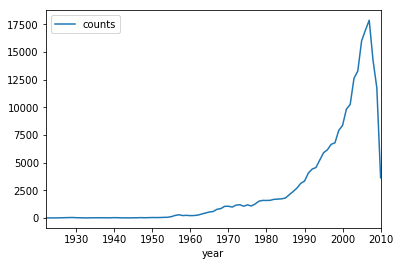

In [29]:
df2_year.iloc[1:, :].plot(x='year', y='counts', kind='line')

In [30]:
genres = set([])
genres_cols = ['genre1_cd2c', 'genre2_cd2c', 'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1']
for col_name in genres_cols:
    genres = genres | set(df2[col_name].unique())
print(genres)
print(len(genres))

{nan, 'Punk', 'World', 'Reggae', nan, 'New Age', 'RnB', 'Rap', 'Rock', 'International', 'Pop', 'Pop_Rock', 'Jazz', 'Electronic', 'Folk', 'Metal', 'Country', 'Vocal', 'Latin', 'Blues'}
20


We have 17 different genres (nan are unkownn and international is the same as world). To do a meaningful analysis of the genre analysis over the year a minimum amount of songs of the analyzed type must be in the dataset. In the following cells we first replace the nan and replace International by World. 

In [31]:
df2[genres_cols] = df2[genres_cols].fillna('Unknown')
df2[genres_cols] = df2[genres_cols].replace('International', 'World')

In [32]:
genres = set([])
genres_cols = ['genre1_cd2c', 'genre2_cd2c', 'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1']
for col_name in genres_cols:
    genres = genres | set(df2[col_name].unique())
    df2[col_name] = df2[col_name].astype(str)
print(genres)
print(len(genres))

{'Punk', 'World', 'Reggae', 'New Age', 'RnB', 'Rap', 'Rock', 'Pop', 'Pop_Rock', 'Jazz', 'Electronic', 'Folk', 'Metal', 'Country', 'Vocal', 'Unknown', 'Latin', 'Blues'}
18


In [33]:
df2[genres_cols].head()

,genre1_cd2c,genre2_cd2c,genre1_cd2,genre2_cd2,genre1_cd1,genre2_cd1
2,Unknown,Unknown,Electronic,Rap,Electronic,Rap
11,Latin,Unknown,Latin,Unknown,Unknown,Unknown
14,World,Unknown,World,Unknown,Unknown,Unknown
15,Pop,Unknown,Pop,Unknown,Unknown,Unknown
17,Unknown,Unknown,Rock,Metal,Unknown,Unknown


For the moment we have 6 columns for the genres, we would like to see if we can summarize these columns in one or two columns.
First we perform a pivot and count the number of different values there are in each column. 

In [37]:
for genre in list(genres):
    df2[genre] = 0
    for col_name in genres_cols:
        df2.loc[df2[col_name] == genre, genre] = 1
df2 = df2.drop(['Unknown'], axis=1)
genres.remove('Unknown')

In [38]:
df2['nb_genre'] = np.sum(df2.iloc[:, -17:].values, axis=1)

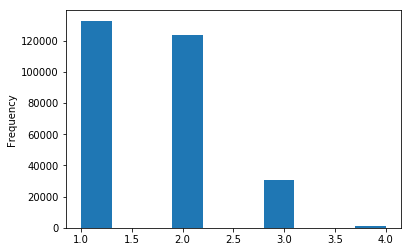

In [39]:
df2['nb_genre'].plot(kind='hist')

So we see that the majority of the songs have 1 or 2 different genres, some also have 3 genres and 4 genres is atypical. We can now drop the 6 columns containing the label genres.

In [41]:
df2 = df2.drop(genres_cols, axis=1)

Now for each genre we plot the number of sample per year.

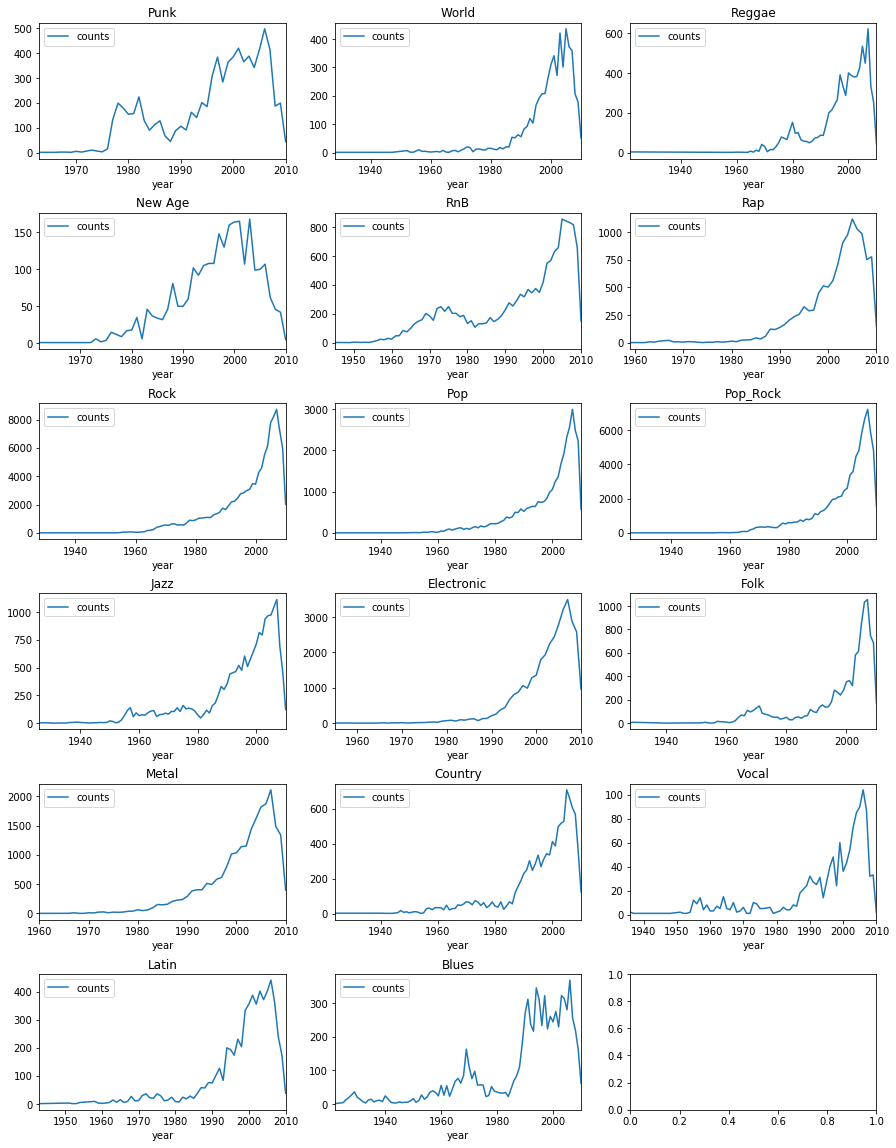

In [42]:
int(len(list(genres))/3.0 + .5)
f, axarr = plt.subplots(int(len(list(genres))/3.0 + .5), 3)
f.set_size_inches(15, 20)
plt.subplots_adjust(hspace=.4)
i = 0
for genre in genres:
    df2[df2[genre] == 1].groupby(['year']).size().reset_index(name='counts').iloc[1:, :]\
    .plot(x='year', y='counts', kind='line', title=genre, ax=axarr[int(i/3), i%3])
    i+=1

These plots are useful to see the data we have in our hands. 

Firstly we observe that most of the music we have is rock, pop, pop_rock, electronic or metal. On the opposite World, Latin, blues are not very represented. This can be explained whether because the dataset is biased but also because some genre are more popular. Indeed Latin music is sub-represented although there is a very important latin culture in the world. These observations could be made more precise by using only the total number of songs for each genre.

Secondly these plots enable us to see some trends in the evolution of the music. If we suppose the dataset is not too much biased for the genre the most represented we can make some interesting observations. We can see that punk music suddenly appears in the middle of the 70's. Rock started in the 60's and grows exponentially since this moment. Indeed these plots are useful to tell something about when the genre appears and how it has evolved since this moment. 

Now we want to look how genre are connected, so let's construct a graph in which nodes are the genre and connection between genre appears when a song has both genres. The weight of the connection is given by the number of songs.

In [43]:
adj_mat_genres = np.zeros([len(genres), len(genres)])
genres = list(genres)
for i in range(len(genres)):
    for j in range(i, len(genres)):
        nb_songs = df2[(df2[genres[i]] == 1) & (df2[genres[j]] == 1)].shape[0]
        adj_mat_genres[i, j] = nb_songs
        adj_mat_genres[j, i] = nb_songs

adj_mat_genres

In [44]:
adj_df = pd.DataFrame(adj_mat_genres, columns=genres)

In [45]:
adj_df['genre'] = genres

In [46]:
adj_df['radius'] = (np.diag(adj_mat_genres))**.5
adj_df['id'] = range(len(adj_df))

In [47]:
adj_df[['radius', 'id', 'genre']].T.to_dict().values()

dict_values([{'radius': 96.39502061828712, 'id': 0, 'genre': 'Punk'}, {'radius': 84.11896337925236, 'id': 1, 'genre': 'World'}, {'radius': 105.28057750601485, 'id': 2, 'genre': 'Reggae'}, {'radius': 58.54912467321779, 'id': 3, 'genre': 'New Age'}, {'radius': 139.57435294494474, 'id': 4, 'genre': 'RnB'}, {'radius': 127.68320171424274, 'id': 5, 'genre': 'Rap'}, {'radius': 366.6619696668854, 'id': 6, 'genre': 'Rock'}, {'radius': 203.51412727375956, 'id': 7, 'genre': 'Pop'}, {'radius': 305.89867603505576, 'id': 8, 'genre': 'Pop_Rock'}, {'radius': 155.80115532305913, 'id': 9, 'genre': 'Jazz'}, {'radius': 204.53850493244542, 'id': 10, 'genre': 'Electronic'}, {'radius': 114.20157617125956, 'id': 11, 'genre': 'Folk'}, {'radius': 162.85269417482783, 'id': 12, 'genre': 'Metal'}, {'radius': 117.21348045340177, 'id': 13, 'genre': 'Country'}, {'radius': 38.961519477556315, 'id': 14, 'genre': 'Vocal'}, {'radius': 92.8654941299512, 'id': 15, 'genre': 'Latin'}, {'radius': 105.99056561788883, 'id': 16,

In [48]:
import json
a = adj_df[['radius', 'id', 'genre']].T.to_dict().values()
list(a)

[{'genre': 'Punk', 'id': 0, 'radius': 96.39502061828712},
 {'genre': 'World', 'id': 1, 'radius': 84.11896337925236},
 {'genre': 'Reggae', 'id': 2, 'radius': 105.28057750601485},
 {'genre': 'New Age', 'id': 3, 'radius': 58.54912467321779},
 {'genre': 'RnB', 'id': 4, 'radius': 139.57435294494474},
 {'genre': 'Rap', 'id': 5, 'radius': 127.68320171424274},
 {'genre': 'Rock', 'id': 6, 'radius': 366.6619696668854},
 {'genre': 'Pop', 'id': 7, 'radius': 203.51412727375956},
 {'genre': 'Pop_Rock', 'id': 8, 'radius': 305.89867603505576},
 {'genre': 'Jazz', 'id': 9, 'radius': 155.80115532305913},
 {'genre': 'Electronic', 'id': 10, 'radius': 204.53850493244542},
 {'genre': 'Folk', 'id': 11, 'radius': 114.20157617125956},
 {'genre': 'Metal', 'id': 12, 'radius': 162.85269417482783},
 {'genre': 'Country', 'id': 13, 'radius': 117.21348045340177},
 {'genre': 'Vocal', 'id': 14, 'radius': 38.961519477556315},
 {'genre': 'Latin', 'id': 15, 'radius': 92.8654941299512},
 {'genre': 'Blues', 'id': 16, 'radius

In [49]:
adj_df = adj_df.iloc[:, :-3]

In [50]:
adj = adj_df.values

In [51]:
edges = []
for i in range(len(adj)):
    for j in range(i+1, len(adj)):
        edge = {'source_id': i, 'target_id': j, 'stroke_width': adj[i, j]/1000}
        edges.append(edge)
edges

[{'source_id': 0, 'stroke_width': 0.010999999999999999, 'target_id': 1},
 {'source_id': 0, 'stroke_width': 0.186, 'target_id': 2},
 {'source_id': 0, 'stroke_width': 0.0, 'target_id': 3},
 {'source_id': 0, 'stroke_width': 0.0070000000000000001, 'target_id': 4},
 {'source_id': 0, 'stroke_width': 0.043999999999999997, 'target_id': 5},
 {'source_id': 0, 'stroke_width': 5.2690000000000001, 'target_id': 6},
 {'source_id': 0, 'stroke_width': 0.11899999999999999, 'target_id': 7},
 {'source_id': 0, 'stroke_width': 4.4269999999999996, 'target_id': 8},
 {'source_id': 0, 'stroke_width': 0.0080000000000000002, 'target_id': 9},
 {'source_id': 0, 'stroke_width': 0.11, 'target_id': 10},
 {'source_id': 0, 'stroke_width': 0.049000000000000002, 'target_id': 11},
 {'source_id': 0, 'stroke_width': 0.187, 'target_id': 12},
 {'source_id': 0, 'stroke_width': 0.021999999999999999, 'target_id': 13},
 {'source_id': 0, 'stroke_width': 0.002, 'target_id': 14},
 {'source_id': 0, 'stroke_width': 0.029000000000000001

In [52]:
%%html
<iframe src="http://www.cbinge.com/file/test.html" width=1000 height = 1000/>

# Year Analysis

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [54]:
df = pd.read_csv("final_merge.csv") #import dataframe
df['album_release'] = df['album_release'].fillna(0).astype(int) #must fill nan with value to convert to int
df = df.loc[df['year'] != 0] #don't take 0, as it means unknown
df.describe()

,Unnamed: 0,song_hotttnesss,artist_latitude,artist_longitude,loudness_x,mode_x,tempo_x,key_x,genre2_cd2c,duration,...,mode_y,speechiness,acousticness,instrumentalness,liveness,valence,tempo_y,duration_ms,track_popularity,album_release
count,5.203790e+05,349099.000000,188960.000000,188960.000000,520379.000000,520379.000000,520379.000000,520379.000000,0.0,520379.000000,...,146243.0,219885.000000,219942.000000,175752.000000,219979.000000,219876.000000,219885.000000,2.199850e+05,219841.000000,520379.000000
mean,5.032707e+05,0.431690,39.934698,-54.412027,-9.693092,0.663566,124.785756,5.315261,NaN,246.792014,...,1.0,0.082549,0.283646,0.254747,0.224016,0.488946,121.642483,2.394201e+05,4.899527,845.338449
std,2.908924e+05,0.214983,15.701568,56.035174,4.938521,0.472490,34.854771,3.600813,NaN,115.333437,...,0.0,0.110330,0.327752,0.350219,0.203055,0.262209,29.419634,1.043991e+05,8.608010,988.505496
min,0.000000e+00,0.000000,-51.800580,-159.540540,-57.004000,0.000000,0.000000,0.000000,NaN,0.313020,...,1.0,0.021600,0.000001,0.000001,0.008600,0.000010,30.716000,4.000000e+03,0.000000,0.000000
25%,2.511270e+05,0.304170,35.149680,-90.180490,-12.167000,0.000000,99.002000,2.000000,NaN,183.196280,...,1.0,0.034400,0.007250,0.000175,0.097400,0.273000,98.943000,1.822930e+05,0.000000,0.000000
50%,5.030970e+05,0.459725,40.714550,-75.162370,-8.608000,1.000000,122.486000,5.000000,NaN,229.929340,...,1.0,0.045700,0.116000,0.016000,0.136000,0.486000,120.099000,2.274670e+05,0.000000,0.000000
75%,7.548480e+05,0.582811,50.848380,-1.546580,-6.124000,1.000000,145.256500,9.000000,NaN,286.980770,...,1.0,0.077400,0.538000,0.573000,0.292000,0.703000,139.709000,2.793070e+05,6.000000,2002.000000
max,1.007806e+06,1.000000,70.695760,178.690960,4.150000,1.000000,280.955000,11.000000,NaN,3024.665670,...,1.0,0.969000,0.996000,0.999000,1.000000,1.000000,246.830000,3.005613e+06,73.000000,2016.000000


We can see that we still have more than 500k tracks to do our year/time analysis, which should be enough to see correlations if there are any.

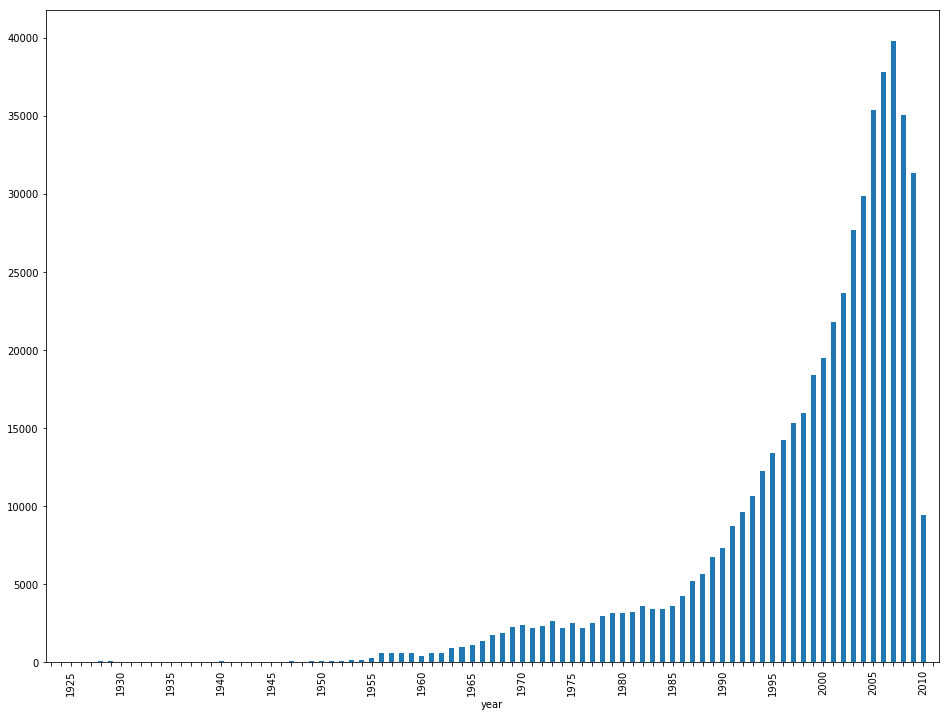

In [55]:
df_c = df.copy()

year_plot = df_c.groupby('year').size().plot(kind='bar', figsize=(16,12))
ax = plt.gca()
for label in ax.get_xticklabels(): #Little trick to avoid cluttering the x axis and only see every 5 years
    label.set_visible(False)
for label in ax.get_xticklabels()[2::5]:
    label.set_visible(True)

## Analysis

We can see, as expected, that the dataset doesn't have many songs before ~1990. It also stops after 2010 (when the dataset got created). The set is therefore not sampled uniformly on the release date. Indeed, as explained on the MSD website, the dataset was chosen using the most popular artist / tracks, which explains why older songs are underrepresented.

In [56]:
def plot_by(df, idx, column, ax=None):
    '''
        Plot a column (y axis) against an index (x axis)
        Will generate a plot matching for each idx value the mean of the column value for this idx.
        :param df: The dataframe containing the data
        :param idx: The x axis series
        :param column: the y axis series
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type idx: string
        :type column: string
        :type ax: Axes
    '''
    df_c = df.copy()
    df_c = df_c[[idx,column]]
    if ax == None:
        axes = plt.gca()
    else:
        axes = ax
    axes.set_xlabel(idx)
    axes.set_ylabel(column)
    df_c.groupby([idx]).mean().plot(ax=ax)
    
def plot_by_year(df, column, ax = None):
    '''
        Plot a column (y axis) against the year (x axis)
        Will generate a plot matching for each year the mean of the column value for this year.
        :param df: The dataframe containing the data
        :param column: the y axis series
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type column: string
        :type ax: Axes
    '''
    plot_by(df,'year',column, ax=ax)
    
def plot_heatmap_by(df, idx, column, ax = None):
    '''
        Plot a heatmap using an index (x axis), and a column (y axis)
        The color value of the heatmap will be the number of samples for this coordinate.
        :param df: The dataframe containing the data
        :param idx: the name of the x axis series
        :param column: the name of the y axis series
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type idx: string
        :type column: string
        :type ax: Axes
    '''
    df_c = df.copy()
    df_c = df_c[[idx,column]]
    if df[column].dtype == np.float or df[column].dtype == np.float64: #Bin the data if needed
        bins = np.linspace(df[column].min(),df[column].max(),20)
        df_c[column] = pd.cut(df_c[column],bins)
    df_c = df_c.dropna()
    df_count = pd.DataFrame(df_c.groupby([idx, column]).size().rename('count'))
    df_c = df_c.join(df_count, on=[idx,column])
    df_c = df_c.reset_index().pivot_table(index=idx, columns=column, values='count', aggfunc='mean')
    if ax==None:
        axes = plt.gca()
    else:
        axes = ax
    axes.set_xlabel(idx)
    axes.set_ylabel(column)
    sns.heatmap(df_c, ax=ax, cbar_kws={'label': 'Number of samples'})

def plot_heatmap_by_year(df, column, ax=None):
    '''
        Plot a heatmap using a column (y axis) against the years
        The color value of the heatmap will be the number of samples for this coordinate.
        :param df: The dataframe containing the data
        :param column: the name of the y axis series
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type column: string
        :type ax: Axes
    '''
    plot_heatmap_by(df, 'year', column, ax=ax)
    
def plot_for_year(df, column, year, ax=None):
    '''
        Plot a stripplot (lineplot) of a feature / column for a given year
        The plot will have jitter to better visualize the data
        :param df: The dataframe containing the data
        :param column: the name of the series
        :param year: the year
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type column: string
        :type year: int
        :type ax: Axes
    '''
    df_c = df.copy()
    df_c = df_c[df_c['year']==year]
    df_c = df_c[[column]]
    if ax == None:
        axes = plt.gca()
    else:
        axes = ax
    axes.set_xlabel(column)
    axes.set_ylabel(year)
    sns.stripplot(df_c, jitter=0.4, ax=axes)
    
def plot_heatmap_for_year(df, column1, column2, year, ax=None):
    '''
        Plot a kdeplot of two features / columns for a given year
        It will allow to see correlation between the two columns
        :param df: The dataframe containing the data
        :param column1: the name of the first series
        :param column2: the name of the second series
        :param year: the year
        :param ax: A custom axis object to plot on
        :type df: DataFrame
        :type column1: string
        :type column2: string
        :type year: int
        :type ax: Axes
    '''
    df_c = df.copy()
    df_c = df_c[df_c['year']==year]
    df_c = df_c[[column1, column2]]
    df_c = df_c.dropna()
    if ax == None:
        axes = plt.gca()
    else:
        axes = ax
    axes.set_xlabel(column1)
    axes.set_ylabel(column2)
    sns.kdeplot(df_c[column1], df_c[column2], cmap="Reds", shade=True, shade_lowest=False, ax=axes)
    
def plot_corr(df):
    '''
        Plot the correlation matrix of a dataframe
        The plot will be triangular with negative values blue and positive values red
        Code taken from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
        :param df: The dataframe
        :type df: DataFrame
    '''
    sns.set(style="white")

    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(16, 12))
    f.suptitle("Correlation heatmap")

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

def ceil(x):
    '''
        Shortcut for np.ceil(x).astype(int)
        :param x: the value to ceil
        :type x: number
        :return: The result of the ceiling as an int
        :rtype: int
    '''
    return np.ceil(x).astype(int)

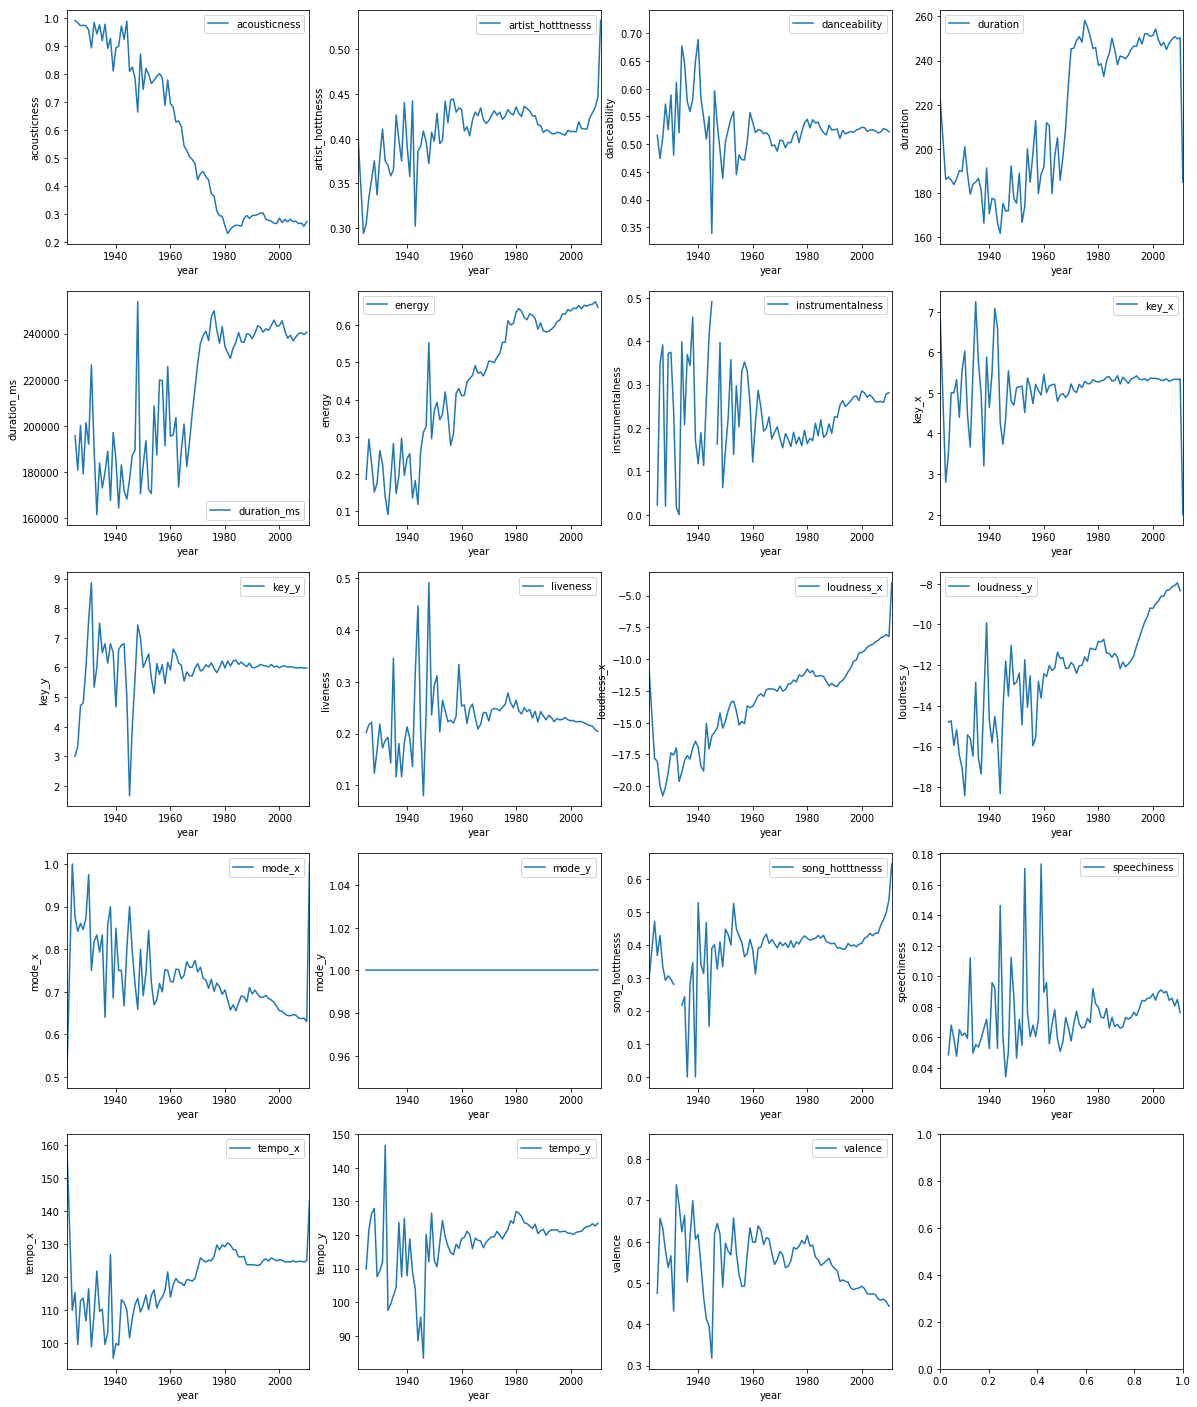

In [57]:
selected = ['song_hotttnesss', 'loudness_x', 'mode_x', 'tempo_x', 'key_x', 'duration', 'artist_hotttnesss', 'danceability', 'energy', 'key_y', 'loudness_y', 'mode_y', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo_y', 'duration_ms']
selected.sort()

n_cols = 4
n_rows = ceil(len(selected)/n_cols)
fig, ax = plt.subplots(n_rows,n_cols)
fig.set_size_inches(20,n_rows*20/n_cols)
idx_r = 0
idx_c = 0

#For each feature, plot the mean of the feature for each year
for col in selected:
    plot_by_year(df,col,ax=ax[idx_r, idx_c])
    if idx_c==n_cols-1:
        idx_r+=1
        idx_c=0
    else:
        idx_c+=1

## Analysis

For most of the data before ~1960, there is a huge variance due to the low number of samples. However, we can still see tendencies for several features.    
- Duration : We can see a clear spike (for both duration and duration_ms) around 1960. We suppose that it is due to the apparition and democratization of the vinyl record (more precisely its more modern iteration). This allowed the musicians to store longer musics (which seemed to be a problem before). However, the duration hasn't increased since, probably because the artists and public feel that the current mean duration is the most optimal one.

- Acousticness : We see a massive drop through the years. This is surely due to the apparition of the electronic music (acousticness is determined by the absence of electronic instruments).

- Loudness : The music seems to get louder and louder. This is probably due to cultural changes (genre, etc).

- Energy : The energy also increases along with the loudness.

- Song hotness : The hotness seems to spike at around 2010. This may be explained by the algorithm, if it is similar to the one of Spotify, the hotness is hugely influenced by the recency of the music, which explains this result. Otherwise, this may be due to the same problem seen with tempo, mode, etc, which all spike at the end of the graph.

- We can drop mode_y, as it is always 1.

- We can't really say much about the other values, except that they seem to stay stable through the years.

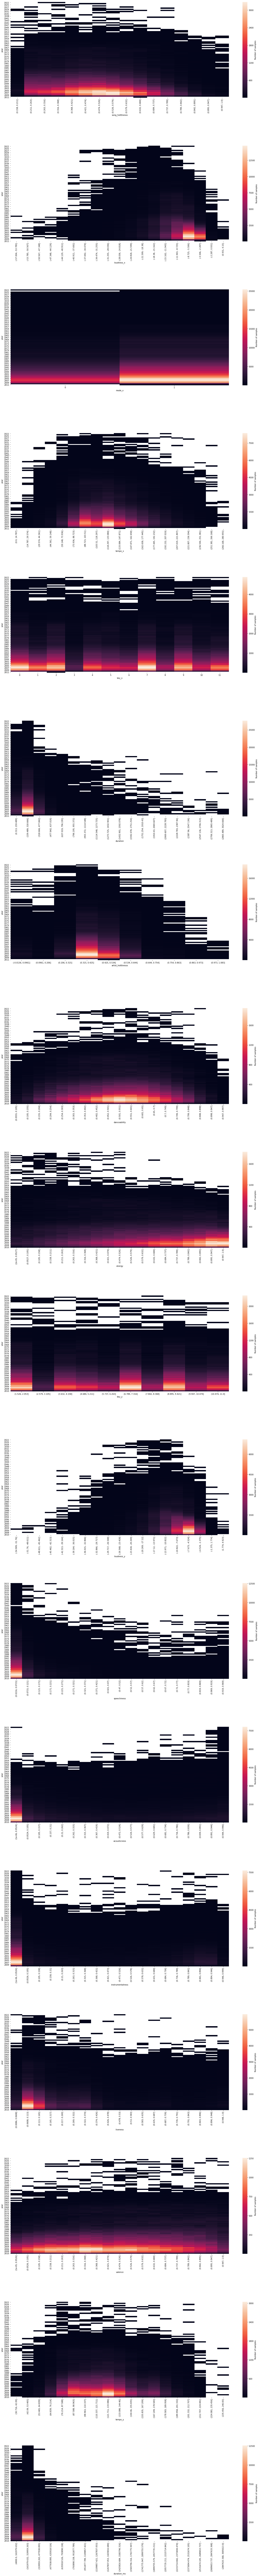

In [58]:
n_cols = 1
selected = ['song_hotttnesss', 'loudness_x', 'mode_x', 'tempo_x', 'key_x', 'duration', 'artist_hotttnesss', 'danceability', 'energy', 'key_y', 'loudness_y', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo_y', 'duration_ms']
n_rows = ceil(len(selected)/n_cols)
fig, ax = plt.subplots(n_rows,n_cols)
fig.set_size_inches(20,n_rows*20/n_cols/2) #Trying to find a good aspect
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)

#For each feature, print the heatmap of the feature regarding the year
for idx,col in enumerate(selected):
    plot_heatmap_by_year(df, col, ax=ax[idx])

## Analysis
These graphs don't show much, except that most of the samples are recent, as seen earlier (and what feature values those recent years samples have). We could perhaps normalize by year to have a better visualization.

In [59]:
n_cols = 2
year_r = range(1960,2012)
n_rows = np.ceil(len(year_r)/n_cols).astype(int)
fig, ax = plt.subplots(n_rows,n_cols)
fig.set_size_inches(20,n_rows/n_cols*20)
idx_r = 0
idx_c = 0

#Plot the song hotness distribution for each year
for year in year_r:
    plot_for_year(df,'song_hotttnesss',year,ax=ax[idx_r, idx_c])
    if idx_c==n_cols-1:
        idx_r+=1
        idx_c=0
    else:
        idx_c+=1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


## Analysis example

The first thing we remark is that a lot of the samples have an hotness of 0. We wondered if this means that the song hasn't been rated, but the description of the dataset just says that the hotness goes from 0 to 1, thus it seems that those songs are just really unpopular (which seems plausible).

We can see that, although the number of samples drastically increases as time goes on, the distribution roughly stays the same (which we could see in the previous graphs). We can also distinguish what looks like lines around 0.2, 0.27, 0.3 mainly (which means an higher concentration of samples). We don't know if it is due to the algorithm used for the rating or if this is just a coincidence at the moment.

# Milestone 3

## Genre Analysis

### Analysis of the distribution of the different features for each genre
Look at the empirical probability function of the genre.
### Look at the influence of the year of these distribution
Is genre time invariant or not?
### Visualize the interesting results obtained
Visualization by using graph evolving with time.

## Year Analysis

- We'll probably discard the data before ~1960, as there are so few samples.
- We'll create an animation for each feature and year to visualize their evolution through time.    
- We'll group the years in decades (for example) to visualize better the differences (as we always speak about the 80s, 90s etc music)
- We'll look further into each feature to see if we can conclude anything regarding the correlation between the features and the hotness.    